In [1]:
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import torchvision
import os
from torchvision import models

In [2]:
LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] 
WINDOW_SIZE = (256, 256) 
IN_CHANNELS = 5 
BATCH_SIZE = 8 
N_CLASSES = len(LABELS) 
WEIGHTS = torch.ones(N_CLASSES) 
CACHE = True 
BASE_LR = 0.01
END_LR = 0.1
WEIGHT_DECAY = 0.0001
EPOCH_SIZE = 10000
CURR_EP = 0
PRETRAIN_MODEL = "../input/fcn8s-rn101-epoch80/FCN8s_RN101_epoch80"

MAIN_FOLDER = "../input/potsdamvaihingen/" 
DATA_FOLDER = MAIN_FOLDER + '3_ortho_irrg/3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
DSM_FOLDER = MAIN_FOLDER + '1_dsm/1_DSM/dsm_potsdam_0{}.tif'
NDSM_FOLDER = MAIN_FOLDER + '1_dsm_normalisation/1_DSM_normalisation/dsm_potsdam_0{}_normalized_lastools.jpg'
LABEL_FOLDER = MAIN_FOLDER + '5_labels_for_participants/5_Labels_for_participants/top_potsdam_{}_label.tif'
ERODED_FOLDER = MAIN_FOLDER + '5_labels_for_participants_no_boundary/5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    

In [3]:
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

In [4]:
def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [5]:
class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, train_ids, dsm_ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                dsm_files=DSM_FOLDER, ndsm_files=NDSM_FOLDER,
                cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in train_ids]
        self.dsm_files = [DSM_FOLDER.format(id) for id in dsm_ids]
        self.ndsm_files = [NDSM_FOLDER.format(id) for id in dsm_ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in train_ids]
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        return EPOCH_SIZE
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            im = np.dstack((io.imread(self.data_files[random_idx]), io.imread(self.dsm_files[random_idx])))
            im = np.dstack((im, io.imread(self.ndsm_files[random_idx])))
            data = np.asarray(im.transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = 1/255*data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

In [6]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)

        out += shortcut
        out = self.relu(out)

        return out

class DeconvBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=2, stride=1, upsample=None):
        super(DeconvBottleneck, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if stride == 1:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                                   stride=stride, bias=False, padding=1)
        else:
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels,
                                            kernel_size=3,
                                            stride=stride, bias=False,
                                            padding=1,
                                            output_padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.upsample = upsample

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.upsample is not None:
            shortcut = self.upsample(x)

        out += shortcut
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, downblock, upblock, num_layers, n_classes=N_CLASSES):
        super(ResNet, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dlayer1 = self._make_downlayer(downblock, 64, num_layers[0])
        self.dlayer2 = self._make_downlayer(downblock, 128, num_layers[1],
                                            stride=2)
        self.dlayer3 = self._make_downlayer(downblock, 256, num_layers[2],
                                            stride=2)
        self.dlayer4 = self._make_downlayer(downblock, 512, num_layers[3],
                                            stride=2)

        self.uplayer1 = self._make_up_block(upblock, 512, 1, stride=2)
        self.uplayer2 = self._make_up_block(upblock, 256, num_layers[2], stride=2)
        self.uplayer3 = self._make_up_block(upblock, 128, num_layers[1], stride=2)
        self.uplayer4 = self._make_up_block(upblock, 64, 2, stride=2)

        upsample = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels,  # 256
                               64,
                               kernel_size=1, stride=2,
                               bias=False, output_padding=1),
            nn.BatchNorm2d(64),
        )
        self.uplayer_top = DeconvBottleneck(self.in_channels, 64, 1, 2, upsample)

        self.conv1_1 = nn.ConvTranspose2d(64, n_classes, kernel_size=1, stride=1,
                                 bias=False)

    def _make_downlayer(self, block, init_channels, num_layer, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != init_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, init_channels*block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(init_channels*block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, init_channels, stride, downsample))
        self.in_channels = init_channels * block.expansion
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels))

        return nn.Sequential(*layers)

    def _make_up_block(self, block, init_channels, num_layer, stride=1):
        upsample = None
        # expansion = block.expansion
        if stride != 1 or self.in_channels != init_channels * 2:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.in_channels, init_channels*2,
                                   kernel_size=1, stride=stride,
                                   bias=False, output_padding=1),
                nn.BatchNorm2d(init_channels*2),
            )
        layers = []
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels, 4))
        layers.append(block(self.in_channels, init_channels, 2, stride, upsample))
        self.in_channels = init_channels * 2
        return nn.Sequential(*layers)

    def forward(self, x):
        img = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.dlayer1(x)
        x1 = x
        x = self.dlayer2(x)
        x2 = x
        x = self.dlayer3(x)
        x3 = x
        x = self.dlayer4(x)
        
        x = self.uplayer1(x)
        x = x + x3
        del(x3)
        x = self.uplayer2(x)
        x = x + x2
        del(x2)
        x = self.uplayer3(x)
        x = x + x1
        del(x1)
        x = self.uplayer4(x)
        x = self.uplayer_top(x)
        
        x = self.conv1_1(x, output_size=img.size())

        return x

def FCN8s_Rn101(**kwargs):
    return ResNet(Bottleneck, DeconvBottleneck, [3, 4, 23, 2], N_CLASSES, **kwargs)

In [7]:
net = FCN8s_Rn101()
net.load_state_dict(torch.load(PRETRAIN_MODEL)['model_state_dict'])
net.cuda()

ResNet(
  (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dlayer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [8]:
train_ids = ['3_11','4_11','5_10','6_7','6_8','6_9','7_7','7_8','7_9','7_10']
# valid: ['3_12','4_12','5_11','6_12']
# train 1: ['2_10','2_11','2_12','3_10','4_10','5_12','6_10','6_11','7_11','7_12']
# train 2: ['3_11','4_11','5_10','6_7','6_8','6_9','7_7','7_8','7_9','7_10']
dsm_ids =   ['3_11','4_11','5_10','6_07','6_08','6_09','7_07','7_08','7_09','7_10']

print("Tiles for training : ", train_ids)
train_set = ISPRS_dataset(train_ids, dsm_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['3_11', '4_11', '5_10', '6_7', '6_8', '6_9', '7_7', '7_8', '7_9', '7_10']


In [9]:
import math
def cyclical_lr(stepsize, min_lr, max_lr):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [10]:
optimizer = optim.Adam(net.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
optimizer.load_state_dict(torch.load(PRETRAIN_MODEL)['optimizer_state_dict'])

step_size = 5*len(train_loader)
clr = cyclical_lr(step_size, min_lr=BASE_LR, max_lr=END_LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

In [11]:
from IPython.display import clear_output
import gc
gc.collect()

def train(net, optimizer, epochs, scheduler=scheduler, weights=WEIGHTS, save_epoch = 10):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.item()
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            gc.collect()
            if iter_ % 100 == 0:
                clear_output()
                #rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(132)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
            gc.collect()
            torch.save({
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, 'FCN8s_RN101_2_epoch{}'.format(e+CURR_EP))
    torch.save(net.state_dict(), './FCN8s_RN101_final')

Train (epoch 40/40) [150/1250 (12%)]	Loss: 0.401904	Accuracy: 99.99847412109375


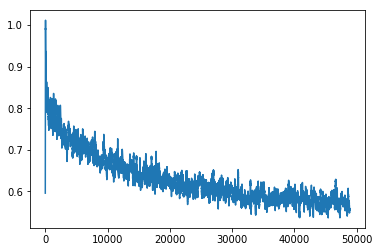

In [12]:
train(net, optimizer, 40, scheduler)